### Inference of CNN Onset Detection

In [1]:
import sys
import glob
import torch
from torch.utils import data
from utils import onsetCNN, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import utils
import librosa

# dangerous solution
os.environ['KMP_DUPLICATE_LIB_OK']='True' 


In [10]:
import os
import random
import shutil

def find_test_song(new_dataset_path, small_dataset_path, destination_path):
    # List all songs in new_dataset_path
    new_songs = set(os.listdir(new_dataset_path))

    # List all songs in small_dataset_path
    train_songs = set(os.listdir(small_dataset_path))

    # Find songs that are in new_dataset_path but not in small_dataset_path
    test_songs = list(new_songs - train_songs)

    if not test_songs:
        print("No new songs available for testing.")
        return None

    # Choose a random song for testing
    test_song = random.choice(test_songs)
    test_song_path = os.path.join(new_dataset_path, test_song)
    
    # Optionally, you can copy the selected test song to a destination folder
    if not os.path.exists(destination_path):
        os.makedirs(destination_path)
    
    shutil.copy(test_song_path, os.path.join(destination_path, test_song))
    
    print(f"Selected song for testing: {test_song}")
    return test_song

# Paths
new_dataset_path = 'New_Dataset/wav'
small_dataset_path = 'Small_Dataset/wav'
destination_path = 'Small_Dataset/inference'

# Find and copy a test song
test_song = find_test_song(new_dataset_path, small_dataset_path, destination_path)
print(test_song)

Selected song for testing: 05-L5-D4-140708_1103_mix_43.wav
05-L5-D4-140708_1103_mix_43.wav


Load Song, Calculate Mean and STD of Song

In [15]:
audio_dir = os.path.join(destination_path, test_song)

!python gen_songlist.py

In [17]:


with open('songlist_inference.txt', 'r') as file:
    songlist = file.read().splitlines()
audio_format = '.wav'
save_dir = destination_path + '/data_pt_inf'

if(os.path.isdir(save_dir) == False):
    os.mkdir(save_dir)

means_song = [np.array([]), np.array([]), np.array([])]
stds_song = [np.array([]), np.array([]), np.array([])]

for item in songlist:
    # Load audio and onsets
    x, fs = librosa.load(audio_dir, sr=44100)

# get mel spectrogram

# updated to melspectrogram new librosa syntax
melgram1 = librosa.feature.melspectrogram(y=x,sr=fs,n_fft=1024, hop_length=441,n_mels=80, fmin=27.5, fmax=16000)
melgram2 = librosa.feature.melspectrogram(y=x,sr=fs,n_fft=2048, hop_length=441,n_mels=80, fmin=27.5, fmax=16000)
melgram3 = librosa.feature.melspectrogram(y=x,sr=fs,n_fft=4096, hop_length=441,n_mels=80, fmin=27.5, fmax=16000)

# log scaling
melgram1 = 10 * np.log10(1e-10 + melgram1)
melgram2 = 10 * np.log10(1e-10 + melgram2)
melgram3 = 10 * np.log10(1e-10 + melgram3)

means_song[0] = np.mean(melgram1, 1)
means_song[1] = np.mean(melgram2, 1)
means_song[2] = np.mean(melgram3, 1)

stds_song[0] = np.std(melgram1, 1)
stds_song[1] = np.std(melgram2, 1)
stds_song[2] = np.std(melgram3, 1)


# prepare for data generation
means = means_song
stds = stds_song

print('save_dir: ', save_dir)

save_dir:  Small_Dataset/inference/data_pt_inf


Gen Data

In [19]:
# function to zero pad ends of spectrogram
def zeropad2d(x,n_frames):
    y = np.hstack((np.zeros([x.shape[0], n_frames]), x))
    y = np.hstack((y,np.zeros([x.shape[0], n_frames])))
    return y

# function to create N-frame overlapping chunks of the full audio spectrogram  
def makechunks(x,duration):
    y = np.zeros([x.shape[1], x.shape[0], duration])
    for i_frame in range(x.shape[1] - duration):
        y[i_frame] = x[:, i_frame:i_frame + duration]
    return y

# context parameters
contextlen = 7 #+- frames
duration = 2 * contextlen + 1

# main
songlist = np.loadtxt('songlist_inference.txt',dtype=str)
audio_format = '.wav'
labels_master = {}
weights_master = {}
filelist = []

# normalize
melgram1 = (melgram1 - np.atleast_2d(means[0]).T) / np.atleast_2d(stds[0]).T
melgram2 = (melgram2 - np.atleast_2d(means[1]).T) / np.atleast_2d(stds[1]).T
melgram3 = (melgram3 - np.atleast_2d(means[2]).T) / np.atleast_2d(stds[2]).T

# zero pad ends
melgram1 = zeropad2d(melgram1, contextlen)
melgram2 = zeropad2d(melgram2, contextlen)
melgram3 = zeropad2d(melgram3, contextlen)

# make chunks
melgram1_chunks = makechunks(melgram1, duration)
melgram2_chunks = makechunks(melgram2, duration)
melgram3_chunks = makechunks(melgram3, duration)

# generate song labels
# hop_dur = 10e-3
# labels = np.zeros(melgram1_chunks.shape[0])
# weights = np.ones(melgram1_chunks.shape[0])
# idxs = np.array(np.round(onsets / hop_dur), dtype=int)
# labels[idxs] = 1

# target smearing
# labels[idxs-1] = 1
# labels[idxs+1] = 1
# weights[idxs-1] = 0.25
# weights[idxs+1] = 0.25

# labels_dict = {}
# weights_dict = {}

for i_chunk in range(melgram1_chunks.shape[0]):
    savepath = os.path.join(save_dir, str(i_chunk) + '.pt')
    #np.save(savepath,np.array([melgram1_chunks[i_chunk],melgram2_chunks[i_chunk],melgram3_chunks[i_chunk]]))
    torch.save(torch.tensor(np.array([melgram1_chunks[i_chunk], melgram2_chunks[i_chunk], melgram3_chunks[i_chunk]])), savepath)


Load Model

In [20]:
# use gpu if available
use_cuda = torch.cuda.is_available()
location = "cuda:0" if use_cuda else "cpu"
device = torch.device(location)

# evaluation tolerance and merge duration for close onsets
tolerance = 60e-3 #+- tolerance/2 seconds
mergeDur = 20e-3
hop_dur = 10e-3
mergeDur_frame = mergeDur / hop_dur
tolerance_frame = tolerance / hop_dur

# fold = int(sys.argv[1]) #cmd line argument

# load model
path_to_saved_model = 'models/saved_model_fold_0.pt'
model = onsetCNN().double().to(device)
model.load_state_dict(torch.load(path_to_saved_model, map_location=location))
model.eval()

onsetCNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 7), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1120, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dout): Dropout(p=0.5, inplace=False)
)

In [21]:
# save_dir = './data_pt_inference'

odf = np.array([])
print(os.path.join(save_dir,'*.pt'))

n_files = len(glob.glob(os.path.join(save_dir,'*.pt')))
for i_file in range(n_files):
    print(i_file)
    x = torch.load(os.path.join(save_dir,'%d.pt'%i_file)).to(device)
    x = x.unsqueeze(0)
    y = model(x).squeeze().cpu().detach().numpy()
    odf = np.append(odf,y)
    

Small_Dataset/inference/data_pt_inf\*.pt
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
2

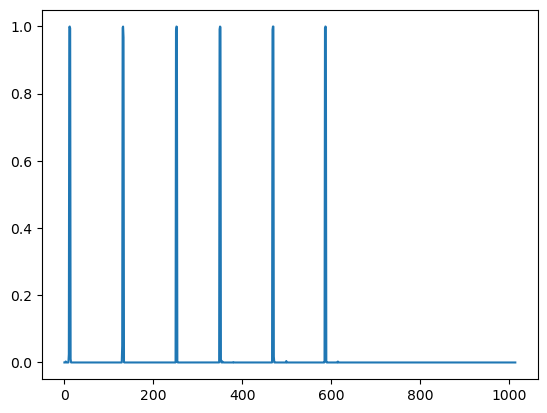

In [5]:
plt.plot(odf)
np.save('../resultats/' +'test1'+'_output', odf)

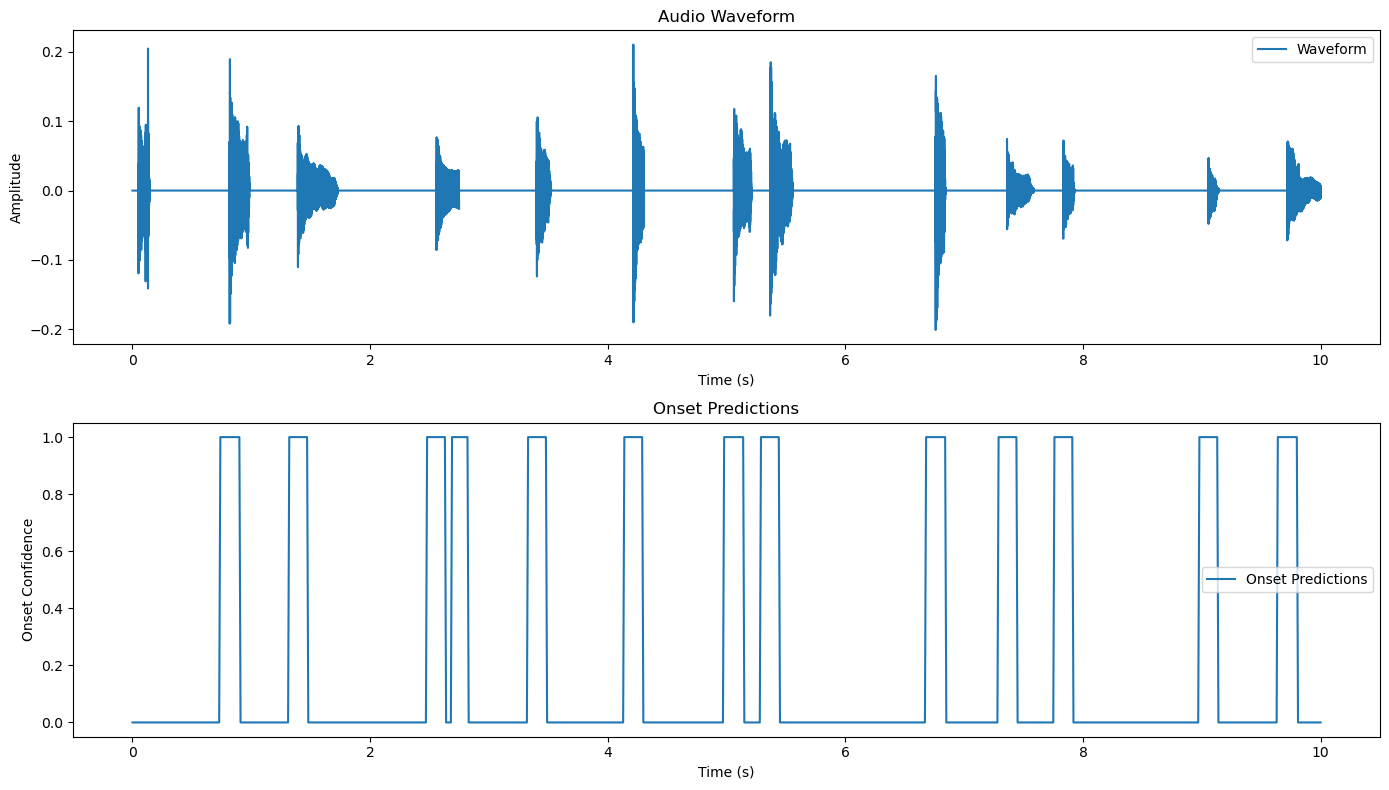

In [22]:
import torch
import librosa
import numpy as np
import matplotlib.pyplot as plt
from utils import onsetCNN

def load_model(model_path, device):
    model = onsetCNN().double().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def preprocess_audio(audio_path, sr=44100, n_fft=1024, hop_length=441, n_mels=80, fmin=27.5, fmax=16000):
    y, sr = librosa.load(audio_path, sr=sr)
    mel_spectrogram1 = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmin=fmin, fmax=fmax)
    mel_spectrogram2 = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=hop_length, n_mels=n_mels, fmin=fmin, fmax=fmax)
    mel_spectrogram3 = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=4096, hop_length=hop_length, n_mels=n_mels, fmin=fmin, fmax=fmax)
    
    mel_spectrogram1_db = librosa.power_to_db(mel_spectrogram1, ref=np.max)
    mel_spectrogram2_db = librosa.power_to_db(mel_spectrogram2, ref=np.max)
    mel_spectrogram3_db = librosa.power_to_db(mel_spectrogram3, ref=np.max)
    
    return mel_spectrogram1_db, mel_spectrogram2_db, mel_spectrogram3_db

def predict_onsets(model, mel_spectrogram1_db, mel_spectrogram2_db, mel_spectrogram3_db, device, hop_length=441, sr=44100):
    contextlen = 7  # +- frames
    duration = 2 * contextlen + 1
    segment_length = duration  # As used during training
    num_segments = mel_spectrogram1_db.shape[1] - segment_length + 1

    onsets = np.zeros(mel_spectrogram1_db.shape[1])

    with torch.no_grad():
        for i in range(num_segments):
            segment1 = mel_spectrogram1_db[:, i:i+segment_length]
            segment2 = mel_spectrogram2_db[:, i:i+segment_length]
            segment3 = mel_spectrogram3_db[:, i:i+segment_length]
            segment = np.stack([segment1, segment2, segment3], axis=0)
            segment = torch.tensor(segment, dtype=torch.float64).unsqueeze(0).to(device)  # Add batch dimension
            prediction = model(segment).squeeze().cpu().numpy()
            onsets[i:i+segment_length] += prediction
    onsets=onsets*10
    onsets = np.where(onsets > 0.02, 1, 0)
    return onsets

def plot_onsets(onsets, audio_path, sr=44100, hop_length=441):
    y, sr = librosa.load(audio_path, sr=sr)
    times = np.arange(len(y)) / sr

    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    plt.plot(times, y, label='Waveform')
    plt.title('Audio Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()

    onset_times = np.arange(len(onsets)) * hop_length / sr


    plt.subplot(2, 1, 2)
    plt.plot(onset_times, onsets, label='Onset Predictions')


    plt.title('Onset Predictions')
    plt.xlabel('Time (s)')
    plt.ylabel('Onset Confidence')
    plt.legend()

    plt.tight_layout()
    plt.show()

def main(audio_path, model_path):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = load_model(model_path, device)
    mel_spectrogram1_db, mel_spectrogram2_db, mel_spectrogram3_db = preprocess_audio(audio_path)
    onsets = predict_onsets(model, mel_spectrogram1_db, mel_spectrogram2_db, mel_spectrogram3_db, device)
    #save onsets in a file .txt
    np.savetxt('onsets.txt', onsets)
    plot_onsets(onsets, audio_path)


if __name__ == "__main__":
    audio_path = 'Small_Dataset/inference/05-L5-D4-140708_1103_mix_43.wav'  
    model_path = 'models/saved_model_fold_0.pt'
    main(audio_path, model_path)


preprocessing
preprocessed
[0 0 0 ... 0 0 0]


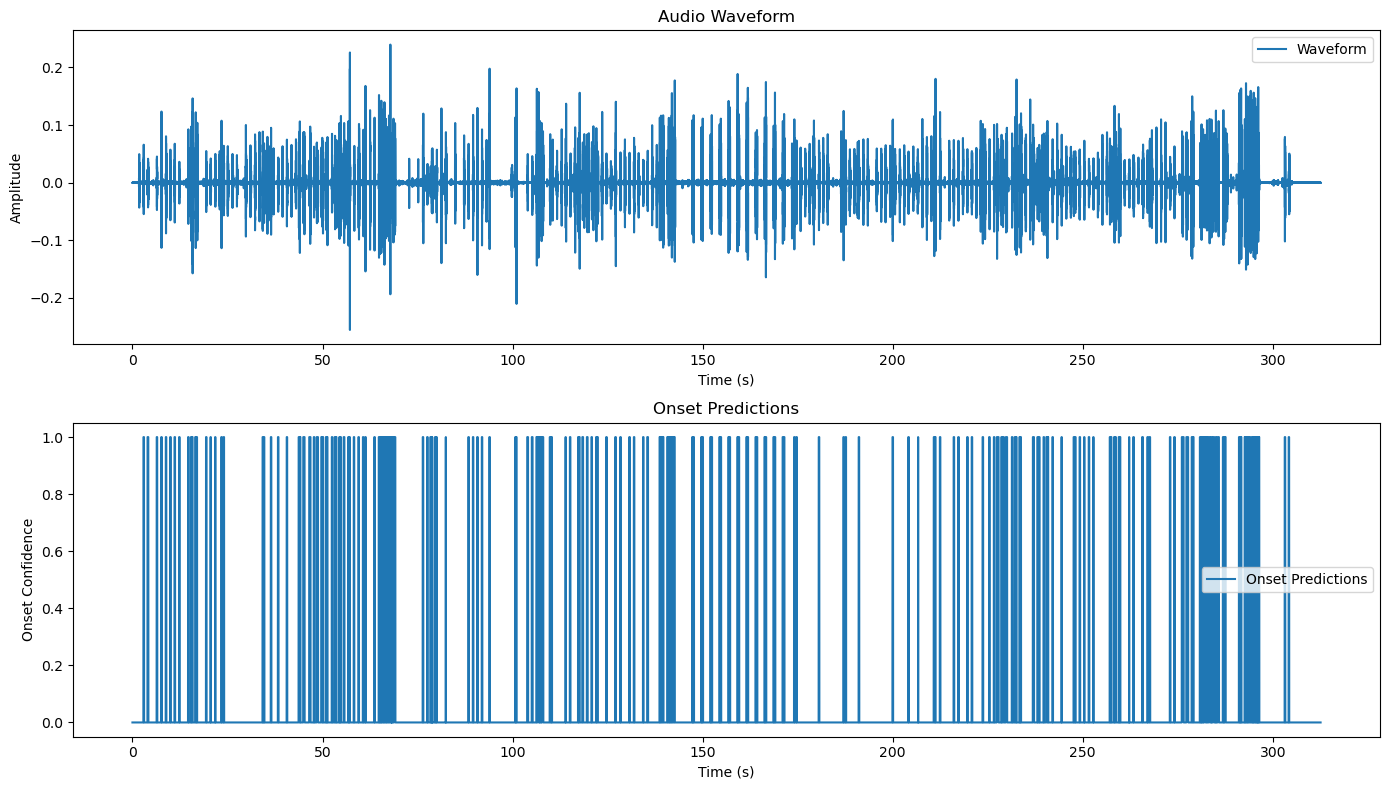

In [5]:
import os
import torch
import librosa
import numpy as np
import matplotlib.pyplot as plt
from utils import onsetCNN

def load_model(model_path, device):
    model = onsetCNN().double().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def preprocess_audio(audio_path, sr=44100, n_fft=1024, hop_length=441, n_mels=80, fmin=27.5, fmax=16000):
    print("preprocessing")
    y, sr = librosa.load(audio_path, sr=sr)
    mel_spectrogram1 = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmin=fmin, fmax=fmax)
    mel_spectrogram2 = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=hop_length, n_mels=n_mels, fmin=fmin, fmax=16000)
    mel_spectrogram3 = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=4096, hop_length=hop_length, n_mels=n_mels, fmin=27.5, fmax=16000)
    
    mel_spectrogram1_db = librosa.power_to_db(mel_spectrogram1, ref=np.max)
    mel_spectrogram2_db = librosa.power_to_db(mel_spectrogram2, ref=np.max)
    mel_spectrogram3_db = librosa.power_to_db(mel_spectrogram3, ref=np.max)
    
    return mel_spectrogram1_db, mel_spectrogram2_db, mel_spectrogram3_db

def predict_onsets(model, mel_spectrogram1_db, mel_spectrogram2_db, mel_spectrogram3_db, device, hop_length=441, sr=44100):
    contextlen = 7  # +- frames
    duration = 2 * contextlen + 1
    segment_length = duration  # As used during training
    num_segments = mel_spectrogram1_db.shape[1] - segment_length + 1

    onsets = np.zeros(mel_spectrogram1_db.shape[1])

    with torch.no_grad():
        for i in range(num_segments):
            segment1 = mel_spectrogram1_db[:, i:i+segment_length]
            segment2 = mel_spectrogram2_db[:, i:i+segment_length]
            segment3 = mel_spectrogram3_db[:, i:i+segment_length]
            segment = np.stack([segment1, segment2, segment3], axis=0)
            segment = torch.tensor(segment, dtype=torch.float64).unsqueeze(0).to(device)  # Add batch dimension
            prediction = model(segment).squeeze().cpu().numpy()
            onsets[i:i+segment_length] += prediction
    onsets = onsets * 10
    onsets = np.where(onsets > 0.02, 1, 0)
    return onsets

def plot_onsets(onsets, audio_path, sr=44100, hop_length=441):
    y, sr = librosa.load(audio_path, sr=sr)
    times = np.arange(len(y)) / sr

    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    plt.plot(times, y, label='Waveform')
    plt.title('Audio Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()

    onset_times = np.arange(len(onsets)) * hop_length / sr

    plt.subplot(2, 1, 2)
    plt.plot(onset_times, onsets, label='Onset Predictions')

    plt.title('Onset Predictions')
    plt.xlabel('Time (s)')
    plt.ylabel('Onset Confidence')
    plt.legend()

    plt.tight_layout()
    plt.show()

def main(audio_path, model_path):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = load_model(model_path, device) 
    mel_spectrogram1_db, mel_spectrogram2_db, mel_spectrogram3_db = preprocess_audio(audio_path)
    print("preprocessed")
    onsets = predict_onsets(model, mel_spectrogram1_db, mel_spectrogram2_db, mel_spectrogram3_db, device)
    print(onsets)
    # save onsets in a file .txt
    save_path = os.path.join(onsets_dir, file_name.replace('.wav', '_onsets.txt'))
    np.savetxt(save_path, onsets)
    plot_onsets(onsets, audio_path)


if __name__ == "__main__":
    audio_dir = '../../wav'
    model_path = 'models/saved_model_0_49.pt'

     # Créer le dossier Onsets s'il n'existe pas
    onsets_dir = os.path.join(audio_dir, 'Onsets')
    if not os.path.exists(onsets_dir):
        os.makedirs(onsets_dir)
        
    for file_name in os.listdir(audio_dir):
        if file_name.endswith('.wav'):
             audio_path = os.path.join(audio_dir, file_name)
             main(audio_path, model_path)


In [6]:
import numpy as np

def read_onsets(file_path):
    onsets = np.loadtxt(file_path)
    
    return onsets


file_path = 'onsets.txt' 
onsets_array = read_onsets(file_path)

print("Onsets Array:")
print(onsets_array)

Onsets Array:
[0. 0. 0. ... 0. 0. 0.]


In [35]:
import csv
import pretty_midi

def csv_to_midi(csv_file, midi_file):
   
    midi = pretty_midi.PrettyMIDI()
    
    
    instrument = pretty_midi.Instrument(program=0)  # Program 0 corresponds to Acoustic Grand Piano
    
    with open(csv_file, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            onset = float(row['onset'])
            offset = float(row['offset'])
            pitch = row['pitch']
            midi_note = int(row['midi_note'])

            # Crée une note
            note = pretty_midi.Note(
                velocity=64,  # Default velocity
                pitch=midi_note,
                start=onset,
                end=offset
            )
            
            
            instrument.notes.append(note)
    
  
    midi.instruments.append(instrument)
    
   
    midi.write(midi_file)


csv_file = '../../Dataset/annotations/06-L6-F#4-140708_1103.1_annotation.csv' 
midi_file = '../../06-L6-F#4-140708_1103.1.mid'      
csv_to_midi(csv_file, midi_file)


In [1]:
import pickle
from madmom.ml.nn import NeuralNetwork

def load_model(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f, encoding='latin1')  # Utilisé pour compatibilité Python 3
    return model

model_path = 'onsets_cnn.pkl'
model = load_model(model_path)


In [2]:
# Inspecter les couches du modèle
for layer in model.layers:
    print(layer)
